In [1]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

In [1]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

In [2]:
import heapq

# Task 1. Algorithm's analysis

## Generating graph

In [3]:

# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """


    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))

    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)

    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)

    if draw:
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue',
                    with_labels=True,
                    node_size=500,
                    arrowsize=20,
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)

        else:
            nx.draw(G, node_color='lightblue',
                with_labels=True,
                node_size=500)

    return G

In [ ]:
G = gnp_random_connected_graph(10, 0.2, False, True)

## Subtask 1.1

### Kruskal's algorithm

In [5]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

In [ ]:
nx.draw(mstk, node_color='lightblue',
        with_labels=True,
        node_size=500)

In [ ]:
nx.draw(G, node_color='lightblue',
                with_labels=True,
                node_size=500)

In [ ]:
mstk.edges().data("weight"), sum(w for _, _, w in mstk.edges().data("weight")), len(mstk.edges())

### Python Implementation

In [ ]:

def Kruskal_algorithm(G: nx.Graph) -> nx.Graph:
    tr: nx.Graph = nx.create_empty_copy(G)
    n = len(G.nodes())
    # print(n)
    edges = G.edges().data("weight")
    edges = sorted(edges, key=lambda x: x[2])

    for u, v, w in edges:
        if not nx.has_path(tr, u, v):
            tr.add_edge(u, v, weight=w)

    return tr

tr = Kruskal_algorithm(G)
nx.draw(tr, node_color='lightblue',
        with_labels=True,
        node_size=500)


In [ ]:
tr.edges().data("weight"), sum(w for _, _, w in tr.edges().data("weight")), len(tr.edges())

### Prim's algorithm

In [11]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

In [ ]:
nx.draw(mstp, node_color='lightblue',
        with_labels=True,
        node_size=500)

In [ ]:
mstp.edges().data("weight"), sum(w for _, _, w in mstp.edges().data("weight")), len(mstp.edges())

### Python implementation

In [ ]:
def Prim_algorithm(G: nx.Graph) -> nx.Graph:
    tr = nx.create_empty_copy(G)

    adj_list = dict.fromkeys(G.nodes(), None)
    for (u, v, wt) in G.edges.data('weight'):
        if not adj_list[u]:
            adj_list[u] = {}
        if not adj_list[v]:
            adj_list[v] = {}
        adj_list[u][v] = wt
        adj_list[v][u] = wt
    #     print(u, v, wt)
    # print(adj_list)

    v = list(G.nodes())[0]
    pr_q = []
    for to, w in adj_list[v].items():
        heapq.heappush(pr_q, (w, to, v))
    connected = set()
    connected.add(v)
    while pr_q != []:
        weight, v, prev = heapq.heappop(pr_q)
        if v in connected:
            continue
        connected.add(v)
        tr.add_edge(prev, v, weight=weight)

        for to, w in adj_list[v].items():
            heapq.heappush(pr_q, (w, to, v))
    return tr

tr = Prim_algorithm(G)
nx.draw(tr, node_color='lightblue',
        with_labels=True,
        node_size=500)

In [ ]:
tr.edges().data("weight"), sum(w for _, _, w in tr.edges().data("weight")), len(tr.edges())

## Subtask 1.2

In [ ]:
G = gnp_random_connected_graph(10, 0.5, True, True)

### Bellman-Ford algorithm

In [ ]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

### Python Implementation

In [18]:
def bellman_ford_algorithm(G, start_node: int):
    dist = dict.fromkeys(G.nodes(), float('inf'))
    dist[start_node] = 0

    for _ in range(len(G.nodes()) - 1):
        for u, v, weight in G.edges(data=True):
            if dist[u] != float('inf') and dist[u] + weight['weight'] < dist[v]:
                dist[v] = dist[u] + weight['weight']

    # check for negative weight cycles
    for u, v, weight in G.edges(data=True):
        if dist[u] != float('inf') and dist[u] + weight['weight'] < dist[v]:
            return "Negative cycle detected"

    return dist

In [ ]:
bellman_ford_algorithm(G, 0)

### Floyd-Warshall algorithm

In [ ]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G)
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")

### Python Implementation

In [21]:
def floyd_warshall_algorithm(G):
    n = len(G.nodes())
    dist = [[float('inf') for _ in range(n)] for _ in range(n)]

    # set distance from node to itself to zero
    for i in range(n):
        dist[i][i] = 0

    # set initial distances
    for u, v, weight in G.edges(data=True):
        dist[u][v] = weight['weight']

    for k in range(n):
        for i in range(n):
            for j in range(n):
                dist[i][j] = min(dist[i][j], (dist[i][k] + dist[k][j]))

    # check for negative weight cycles
    for i in range(n):
        if dist[i][i] < 0:
            return "Negative cycle detected"

    return dist

In [ ]:
fl_w = floyd_warshall_algorithm(G)
fl_w

In [ ]:
for i in range(len(fl_w)):
    print(f"Distances with {i} source: { {k: dist for k, dist in zip(range(len(fl_w)), fl_w[i])} }")

---

## Some useful explanations
### How to get list of edges for your algorithm

In [24]:
edges = list(G.edges()) # by default G.edges are EdgesView class

In [ ]:
edges[:5]

### To get edges with weights

In [26]:
edges = list(G.edges(data=True))

In [ ]:
edges[2]

In [ ]:
nodes = list(G.nodes())
print(nodes)

# Time measuring

Read more on this: https://realpython.com/python-timer/

Recall that you should measure times for 5, 10, 20, 50, 100, 200, 500 nodes 1000 times (and take mean of time taken for each node amount).

Then you should build the plot for two algorithms (x - data size, y - mean time of execution).

In [29]:
import time
from tqdm import tqdm

In [30]:
NUM_OF_ITERATIONS = 1000
num_nodes = [5, 10, 20, 50, 100, 200, 500]
completenesses = [0, 0.2, 0.4, 0.5, 0.75, 1]

## Minimum spanning tree

In [ ]:
measures_MST = {
    "nx_prim": {
        "time": {},
        "alg": lambda g: tree.minimum_spanning_tree(g, algorithm="prim")
    },
    "my_prim": {
        "time": {},
        "alg": lambda g: Prim_algorithm(g)
    },
    "nx_krustal": {
        "time": {},
        "alg": lambda g: tree.minimum_spanning_tree(g, algorithm="kruskal")
    },
    "my_krustal": {
        "time": {},
        "alg": lambda g: Kruskal_algorithm(g)
    },
}

for n in num_nodes:
    for k in measures_MST:
        measures_MST[k]["time"][n] = 0

    for i in tqdm(range(NUM_OF_ITERATIONS)):

        # note that we should not measure time of graph creation
        G = gnp_random_connected_graph(n, completenesses[i%len(completenesses)], False)

        for k in measures_MST:
            start = time.time()
            gr = measures_MST[k]["alg"](G)
            end = time.time()

            measures_MST[k]["time"][n] += end - start

    for k in measures_MST:
        measures_MST[k]["time"][n] = measures_MST[k]["time"][n] / NUM_OF_ITERATIONS
measures_MST

## Shortest path

# Plotting time measures

## Minimum spanning tree

Use this if you don't want to measure

In [30]:
# # Data: number of nodes and measured times for each algorithm.
# num_nodes = [5, 10, 20, 50, 100, 200, 500]

# measures_MST = {
#     'nx_prim': {
#         'time': {
#             5: 3.6245107650756835e-05,
#             10: 0.00013869738578796387,
#             20: 0.0001194601058959961,
#             50: 0.000502967119216919,
#             100: 0.00245829701423645,
#             200: 0.015145911455154419,
#             500: 0.11887391948699952
#         },
#         'alg': lambda g: None  # placeholder function
#     },
#     'my_prim': {
#         'time': {
#             5: 2.8157472610473633e-05,
#             10: 6.421422958374024e-05,
#             20: 0.00015464949607849122,
#             50: 0.0008819258213043213,
#             100: 0.005444227933883667,
#             200: 0.030584785461425783,
#             500: 0.2457535240650177
#         },
#         'alg': lambda g: None
#     },
#     'nx_krustal': {
#         'time': {
#             5: 3.651738166809082e-05,
#             10: 7.623982429504395e-05,
#             20: 0.00015038323402404786,
#             50: 0.0006659302711486816,
#             100: 0.003551886320114136,
#             200: 0.018301385402679442,
#             500: 0.15191850209236146
#         },
#         'alg': lambda g: None
#     },
#     'my_krustal': {
#         'time': {
#             5: 5.860638618469238e-05,
#             10: 9.623982429504395e-05,
#             20: 0.00095038323402404786,
#             50: 0.005616315841674805,
#             100: 0.048421209573745724,
#             200: 0.3302415544986725,
#             500: 3.673677587032318
#         },
#         'alg': lambda g: None
#     }
# }

### Absolute time measures limited to 1 second

my_kruskal takes an average of 3.673677587032318 seconds for 500 nodes

In [ ]:
# Extract algorithm names.
algorithms = list(measures_MST.keys())

# Prepare the times for each algorithm in the order of num_nodes.
times = {
    alg: [measures_MST[alg]['time'][n] for n in num_nodes]
    for alg in algorithms
}

# Set up the bar plot parameters.
x = np.arange(len(num_nodes))  # positions for groups (each group corresponds to a graph size)
bar_width = 0.2  # width of each individual bar
offset = -bar_width * (len(algorithms) - 1) / 2  # centering the grouped bars

fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar for each algorithm.
for i, alg in enumerate(algorithms):
    ax.bar(x + offset + i * bar_width, times[alg],
           width=bar_width, label=alg)

# Set the labels and title.
ax.set_xlabel("Number of Nodes")
ax.set_ylabel("Time (seconds)")
ax.set_title("Execution Time of Different MST Algorithms")
ax.set_xticks(x)
ax.set_xticklabels(num_nodes)
ax.legend()
ax.set_ylim(0, 1)

# Display the plot.
plt.tight_layout()
plt.show()


### Grouped by number of nodes

In [ ]:
# List of algorithm names.
algorithms = list(measures_MST.keys())

# Decide on a grid layout for subplots.
n_plots = len(num_nodes)
n_cols = 4                     # Number of subplot columns (you can adjust this)
n_rows = (n_plots + n_cols - 1) // n_cols  # Compute the number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()  # Flatten in case we have a 2D array of axes

# Create a bar plot for each graph size.
for i, nodes in enumerate(num_nodes):
    # Extract times for the current number of nodes for each algorithm.
    times = [measures_MST[alg]['time'][nodes] for alg in algorithms]

    # Plot bars for each algorithm.
    axes[i].bar(algorithms, times, color='skyblue')

    # Set title and labels.
    axes[i].set_title(f"Graph Size: {nodes} Nodes")
    axes[i].set_ylabel("Time (seconds)")

    # Optionally, adjust y-axis limits so the bars are clearly visible.
    max_time = max(times)
    axes[i].set_ylim(0, max_time * 1.2)  # a little extra space above the tallest bar

    # Rotate x-labels if necessary for better readability.
    axes[i].tick_params(axis='x', rotation=45)

# If there are any unused subplots, remove them.
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Grouped by number of nodes without my_kruskal

In [ ]:
# List of algorithm names.
algorithms = list(measures_MST.keys())[:-1]

# Decide on a grid layout for subplots.
n_plots = len(num_nodes)
n_cols = 3                     # Number of subplot columns (you can adjust this)
n_rows = (n_plots + n_cols - 1) // n_cols  # Compute the number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()  # Flatten in case we have a 2D array of axes

# Create a bar plot for each graph size.
for i, nodes in enumerate(num_nodes):
    # Extract times for the current number of nodes for each algorithm.
    times = [measures_MST[alg]['time'][nodes] for alg in algorithms]

    # Plot bars for each algorithm.
    axes[i].bar(algorithms, times, color='skyblue')

    # Set title and labels.
    axes[i].set_title(f"Graph Size: {nodes} Nodes")
    axes[i].set_ylabel("Time (seconds)")

    # Optionally, adjust y-axis limits so the bars are clearly visible.
    max_time = max(times)
    axes[i].set_ylim(0, max_time * 1.2)  # a little extra space above the tallest bar

    # Rotate x-labels if necessary for better readability.
    axes[i].tick_params(axis='x', rotation=45)

# If there are any unused subplots, remove them.
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Shortest Path

Lazy measures

## Task 2. Decision Tree Classifier 

In [4]:
# scikit-learn package
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### General idea

#### You are expected to write a quite simple, yet good core logic of decision tree classifier class. Additionaly, you need to test your results and write down a report on what you've done, which principles used and explain the general process.

#### Hopefully, you have already learned what is decision tree classifier and how it work. For better understanding, and in case if something is still unclear for you, here are some useful links on basics of DTC:
- https://www.youtube.com/watch?v=ZVR2Way4nwQ
- https://towardsdatascience.com/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e
- https://towardsdatascience.com/decision-tree-from-scratch-in-python-46e99dfea775
- https://www.kaggle.com/code/prashant111/decision-tree-classifier-tutorial
- https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b6057

#### Also, for those interested to learn more about machine learning and particulary Desicion Trees - here is a great course on Coursera (you may be interested in the whole course or just this particular week):
- https://www.coursera.org/learn/advanced-learning-algorithms/home/week/4


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)


### Dataset
#### You can use Iris dataset for this task. It is a very popular dataset for machine learning and data science. It contains 150 samples of 3 different species of Iris flowers (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. 
Read more on this: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
https://en.wikipedia.org/wiki/Iris_flower_data_set
#### However, using more interesting and intricate datasets is much appreciated. You can use any dataset you want, but it should be a classification one. For example you can use breast cancer or wine datasets, which are also available in sklearn.datasets. Or you can use any other dataset you find interesting.
P.S. In case you are not sure if your dataset is suitable, feel free to ask assistants :).

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [5]:
# Load dataset
iris = load_iris()
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [6]:
iris.data.shape

(150, 4)

This means that we have 150 entries (samples, infos about a flower). The columns being: Sepal Length, Sepal Width, Petal Length and Petal Width(features). Let's look at first two entries:

In [7]:
iris.data[0:2]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2]])

### To undestand data little bit better, let's plot some features

Text(0, 0.5, 'Sepal width')

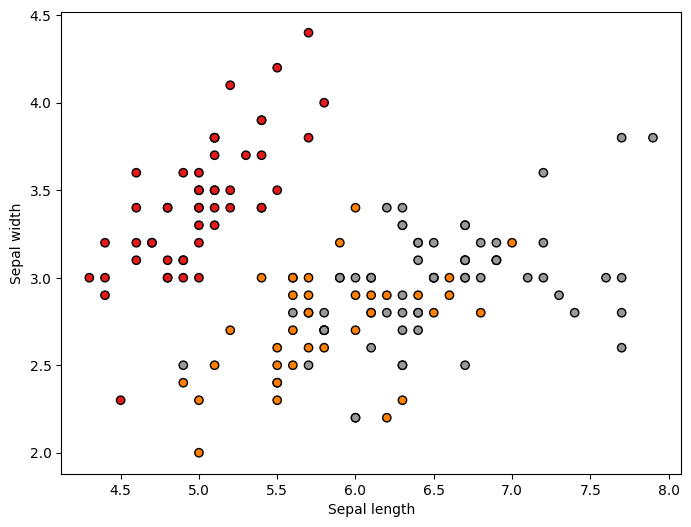

In [8]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

From this we can clearly see, that even basing on those two parameters, we can clearly divide (classify) out data into several groups. For this, we will use decision tree classifier: https://scikit-learn.org/stable/modules/tree.html#tree

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Example of usage


**Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression**. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [9]:
clf = DecisionTreeClassifier()

X, y = iris.data, iris.target
X.shape, y.shape

((150, 4), (150,))

### Train / test split

We train our model using training dataset and evaluate its performance basing on the test dataset. Reason to use two separate datasets is that our model learns its parameters from data, thus test set allows us to check its possibilities on completely new data.

In [10]:
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)
X_test.shape, y_test.shape

((30, 4), (30,))

### Model learning

It learns its parameters (where it should split data and for what threshold value) basing on the training dataset. It is done by minimizing some cost function (e.g. Gini impurity or entropy).

In [11]:
clf = clf.fit(X, y)

### Visualization of produced tree

You do not need to understand this piece of code :)

In [12]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("iris")

'iris.pdf'

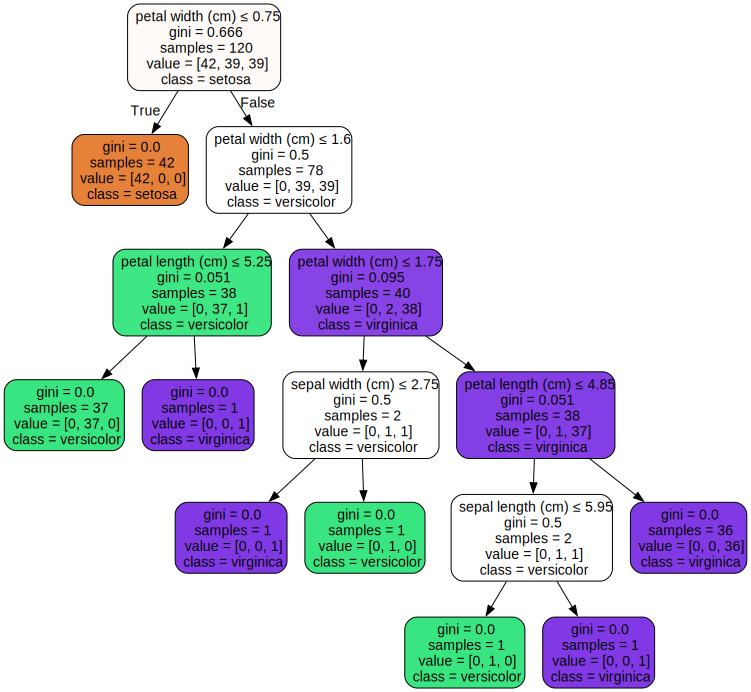

In [18]:
dot_data = tree.export_graphviz(clf, out_file=None,
                     feature_names=iris.feature_names,
                     class_names=iris.target_names,
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Prediction step

Now we can use our model to predict which type has a flower, basing on its parameters.

This is conducted basically via traversing the tree that you can see above.

In [46]:
predictions = clf.predict(X_test)

### We can also measure the accuracy of our model

In [47]:
sum(predictions == y_test) / len(y_test)

np.float64(0.9333333333333333)

To get clearer intuition about predicion, let's look at those X, that should be labeled to some flower

In [ ]:
y_test


Here you can traverse the tree above by yourself and make sure that prediction works

In [ ]:
X_test[1]

In [ ]:
clf.predict([X_test[1]])

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Finally, it is your turn to write such classifier by yourself!

####  Gini impurity

Decision trees use the concept of Gini impurity to describe how “pure” a node is. A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

For example, if a node contains five samples, with two belonging to the first class (first flower), two of class 2, one of class 3 and none of class 4, then

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$

#### Remarks 
- We recommend using additional functions in `DecisionTreeClassifier` class, to make the implementation process easier.
- [use this hint](https://arc.net/l/quote/pqvyjqei)

In [14]:

class Node:
    def __init__(self, X: npt.NDArray, y: npt.NDArray):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """

        self.X = X
        self.y = y
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None
        self.gini = self.calculate_gini(y)

    @staticmethod
    def calculate_gini(y: npt.NDArray) -> float:
        _, counts = np.unique_counts(y)
        total = np.sum(counts)
        return 1 - np.sum((counts/total)**2)

In [40]:
class MyDecisionTreeClassifier:
    def __init__(self, max_depth: int) -> None:
        self.max_depth = max_depth
        self.tree = None
        self.number_of_classes = None


    def fit(self, X: npt.NDArray, y: npt.NDArray) -> None:
        """
        Basically, function that performs all the training (building of a tree)
        We recommend to use it as a wrapper of recursive building function
        """
        self.number_of_classes = np.unique(y).size
        self.tree = Node(X, y)

        features_count = X.shape[1]
        uniques = [np.unique(X[:, f_i]) for f_i in range(features_count)]


        def inner(root: Node, depth: int):
            if depth >= self.max_depth:
                return

            max_info_gain = 0
            for feature_index in range(features_count):
                for threshold in uniques[feature_index]:
                    left_data, right_data = self.split_data(root.X, root.y, feature_index, threshold)
                    if left_data[0].size == 0 or right_data[0].size == 0:
                        continue

                    left = Node(left_data[0], left_data[1])
                    right = Node(right_data[0], right_data[1])

                    #maximize information gain
                    left_info = left.gini * left.y.size / root.y.size
                    right_info = right.gini * right.y.size / root.y.size
                    cur_info_gain = root.gini - left_info - right_info
                    if cur_info_gain > max_info_gain:
                        max_info_gain = cur_info_gain
                        root.feature_index = feature_index
                        root.threshold = threshold
                        root.left = left
                        root.right = right

            if root.left is None:
                return
            if root.left.gini != 0:
                inner(root.left, depth+1)
            if root.right.gini != 0:
                inner(root.right, depth+1)

        inner(self.tree, 0)


    @staticmethod
    def split_data(X: npt.NDArray, y: npt.NDArray, feature_index: int, threshold) \
        -> tuple[tuple[npt.NDArray, npt.NDArray], tuple[npt.NDArray, npt.NDArray]]:
        left, right = ([], []), ([], [])
        for i in range(X.shape[0]):
            if X[i, feature_index] <= threshold:
                left[0].append(X[i])
                left[1].append(y[i])
            else:
                right[0].append(X[i])
                right[1].append(y[i])
        return (np.array(left[0]), np.array(left[1])), (np.array(right[0]), np.array(right[1]))

    def predict(self, X_test: npt.NDArray) -> list:
        """
        Traverse the tree while there is a child
        and return the predicted class for it
        """

        def classify(node: Node, X: npt.ArrayLike) -> int:
            if node.left is None:
                ch, w = np.unique_counts(node.y)
                return random.choices(ch, weights=w)[0]

            if X[node.feature_index] <= node.threshold:
                return classify(node.left, X)
            return classify(node.right, X)

        predictions = []
        for X in X_test:
            predictions.append(classify(self.tree, X))

        return predictions

my_clf = MyDecisionTreeClassifier(5)
my_clf.fit(X, y)

In [45]:
my_predictions = list(my_clf.predict(X_test))
sum(my_predictions == y_test) / len(y_test)

np.float64(0.9666666666666667)

In [33]:
ch, w = np.unique_counts(my_clf.tree.y)
random.choices(ch, weights=w)

[np.int64(2)]

In [16]:

def evaluate(X_test: list[list], y_test: list) -> float:
    """
    Returns accuracy of the model (ratio of right guesses to the number of samples)
    """
    pass

***put your code below, with usage and evaluation of Decision classifier tree*** (delete this)